In [22]:
import pickle
import xarray as xr
import cartopy as cp
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm

from scipy import interpolate

## objective:

process time-series of Nanoose S1500 output, bin into bi-weekly timeperiods (24 per year, 1st and second half of each month), derive climatology, ascertain any trend from 1980-2018. 

- here I open data and visualize raw, uninterpolated data (time and depths, coloured by temperature)

- note that there are some spurious obs below 400 meters.

Following communication (2023-03-22) with GO, we are disregarding observations below 400m. 


- preprocessing - resample to daily, get spatial mean (NEEDS WEIGHTING NEEDS LATITUDE OF BOX)
- shoved into a batchscript for the full ts, an interactive node will run out of memory
- (runner.py run from extractRunner.bsub)


In [23]:

runtest = False
if runtest:
    %reset
    import xarray as xr
    import glob
    import numpy as np

    def make_yearlist(yrst, yrend):
        yrs = np.arange(yrst,yrend+1,1)
        ylist = []
        baseDir = '/gpfs/home/mep22dku/scratch/NanooseObs/SS1500-extract/'
        for i in range(0,len(yrs)):
            ty = yrs[i]
            for m in range(1,13):
                if m < 10:
                    tm = f'0{m}'
                else:
                    tm = m
                tstr = f'y{ty}m{tm}'
                tfi= f'{baseDir}/*{tstr}*.nc'
                t2 = glob.glob(tfi)
                # print(t2)
                ylist.append(t2[0])
        return ylist

    tylist = make_yearlist(1980, 1981)

    tdat = xr.open_mfdataset(tylist)
    tdat_daily = tdat.resample(time_counter = 'D').mean().mean(dim = ['y','x'])
    tdat_daily### this needs to change to be weighted
    #tdat_daily.to_netcdf('SS150_ts_timeseries.nc')

In [24]:
t_2010 = xr.open_dataset('./SS150_ts_timeseries_2010-2018.nc')

In [25]:
v = xr.open_dataset('/gpfs/home/mep22dku/scratch/NanooseObs/SS1500-extract/SalishSea1500-RUN203_1h_grid_T_y2016m05_clipped.nc')
q = v.votemper.values
print(np.nanmax(q))

17.473503


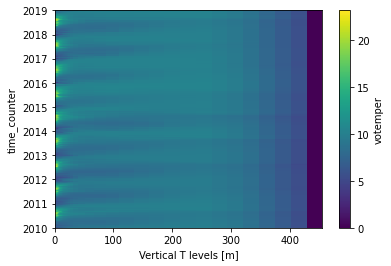

In [26]:
t_2010.votemper.plot()

In [27]:
t_1980 = xr.open_dataset('./SS150_ts_timeseries_1980-1989.nc')
t_1990 = xr.open_dataset('./SS150_ts_timeseries_1990-1999.nc')
t_2000 = xr.open_dataset('./SS150_ts_timeseries_2000-2009.nc')
t_2010 = xr.open_dataset('./SS150_ts_timeseries_2010-2018.nc')

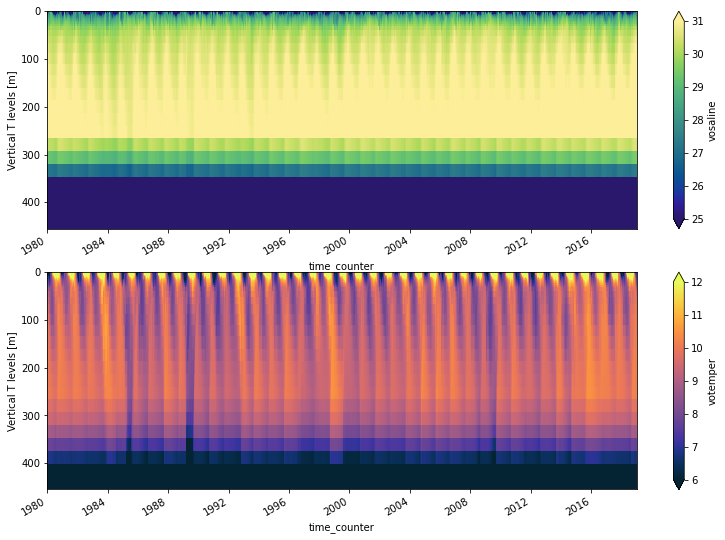

In [28]:
votemper = xr.concat([t_1980.votemper, t_1990.votemper, t_2000.votemper, t_2010.votemper,], dim = 'time_counter')
vosaline = xr.concat([t_1980.vosaline, t_1990.vosaline, t_2000.vosaline, t_2010.vosaline,], dim = 'time_counter')

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

xr.plot.pcolormesh(vosaline.T, ax = axs[0], cmap = cm.cm.haline, vmin = 25, vmax = 31)


xr.plot.pcolormesh(votemper.T, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()


- set up bimonthly time periods (day <= 15 in a given month is the first time-period of that month)

In [34]:
dates_all = pd.to_datetime(votemper.time_counter)
print(len(dates_all))

def the_timepd(date):
    tpd = -99
    if ((date.month == 1) & (date.day <= 15)): tpd = 1
    if ((date.month == 1) & (date.day > 15)): tpd = 2   
    if ((date.month == 2) & (date.day <= 15)): tpd = 3
    if ((date.month == 2) & (date.day > 15)): tpd = 4
    if ((date.month == 3) & (date.day <= 15)): tpd = 5
    if ((date.month == 3) & (date.day > 15)): tpd = 6
    if ((date.month == 4) & (date.day <= 15)): tpd = 7
    if ((date.month == 4) & (date.day > 15)): tpd = 8   
    if ((date.month == 5) & (date.day <= 15)): tpd = 9
    if ((date.month == 5) & (date.day > 15)): tpd = 10
    if ((date.month == 6) & (date.day <= 15)): tpd = 11
    if ((date.month == 6) & (date.day > 15)): tpd = 12
    if ((date.month == 7) & (date.day <= 15)): tpd = 12+ 1
    if ((date.month == 7) & (date.day > 15)): tpd = 12+ 2   
    if ((date.month == 8) & (date.day <= 15)): tpd = 12+ 3
    if ((date.month == 8) & (date.day > 15)): tpd = 12+ 4
    if ((date.month == 9) & (date.day <= 15)): tpd = 12+ 5
    if ((date.month == 9) & (date.day > 15)): tpd = 12+ 6
    if ((date.month == 10) & (date.day <= 15)): tpd = 12+ 7
    if ((date.month == 10) & (date.day > 15)): tpd = 12+ 8   
    if ((date.month == 11) & (date.day <= 15)): tpd = 12+ 9
    if ((date.month == 11) & (date.day > 15)): tpd = 12+ 10
    if ((date.month == 12) & (date.day <= 15)): tpd = 12+ 11
    if ((date.month == 12) & (date.day > 15)): tpd = 12+ 12    
    
    return tpd

timeperiod = np.zeros(len(dates_all)).astype(int)
for i in range(0,len(timeperiod)):
    timeperiod[i] = int(the_timepd(dates_all[i]))


14249


In [36]:
timeperiod

array([ 1,  1,  1, ..., 24, 24,  1])

- format this interpolated-to-model-depths time-series (nans where no data) as an xarray object, save as netcdf

- we now need to resample our time-series such that there are 24 time-periods per year (for the purposes of graphing, as well as finding any trends) 
- to make a tidy xarray object, i assign the dates manually, 2 nominal "days" per month, Jan 1- Jan 15 is Jan 7, Jan 16- Jan 31 is Jan 23, etc)

In [41]:
tdt = np.array([
'1980-01-07', '1980-01-23','1980-02-07', '1980-02-23',
'1980-03-07', '1980-03-23','1980-04-07', '1980-04-23',
'1980-05-07', '1980-05-23','1980-06-07', '1980-06-23',
'1980-07-07', '1980-07-23','1980-08-07', '1980-08-23',
'1980-09-07', '1980-09-23','1980-10-07', '1980-10-23',
'1980-11-07', '1980-11-23','1980-12-07', '1980-12-23',
'1981-01-07', '1981-01-23','1981-02-07', '1981-02-23',
'1981-03-07', '1981-03-23','1981-04-07', '1981-04-23',
'1981-05-07', '1981-05-23','1981-06-07', '1981-06-23',
'1981-07-07', '1981-07-23','1981-08-07', '1981-08-23',
'1981-09-07', '1981-09-23','1981-10-07', '1981-10-23',
'1981-11-07', '1981-11-23','1981-12-07', '1981-12-23',
'1982-01-07', '1982-01-23','1982-02-07', '1982-02-23',
'1982-03-07', '1982-03-23','1982-04-07', '1982-04-23',
'1982-05-07', '1982-05-23','1982-06-07', '1982-06-23',
'1982-07-07', '1982-07-23','1982-08-07', '1982-08-23',
'1982-09-07', '1982-09-23','1982-10-07', '1982-10-23',
'1982-11-07', '1982-11-23','1982-12-07', '1982-12-23',
'1983-01-07', '1983-01-23','1983-02-07', '1983-02-23',
'1983-03-07', '1983-03-23','1983-04-07', '1983-04-23',
'1983-05-07', '1983-05-23','1983-06-07', '1983-06-23',
'1983-07-07', '1983-07-23','1983-08-07', '1983-08-23',
'1983-09-07', '1983-09-23','1983-10-07', '1983-10-23',
'1983-11-07', '1983-11-23','1983-12-07', '1983-12-23',
'1984-01-07', '1984-01-23','1984-02-07', '1984-02-23',
'1984-03-07', '1984-03-23','1984-04-07', '1984-04-23',
'1984-05-07', '1984-05-23','1984-06-07', '1984-06-23',
'1984-07-07', '1984-07-23','1984-08-07', '1984-08-23',
'1984-09-07', '1984-09-23','1984-10-07', '1984-10-23',
'1984-11-07', '1984-11-23','1984-12-07', '1984-12-23',
'1985-01-07', '1985-01-23','1985-02-07', '1985-02-23',
'1985-03-07', '1985-03-23','1985-04-07', '1985-04-23',
'1985-05-07', '1985-05-23','1985-06-07', '1985-06-23',
'1985-07-07', '1985-07-23','1985-08-07', '1985-08-23',
'1985-09-07', '1985-09-23','1985-10-07', '1985-10-23',
'1985-11-07', '1985-11-23','1985-12-07', '1985-12-23',
'1986-01-07', '1986-01-23','1986-02-07', '1986-02-23',
'1986-03-07', '1986-03-23','1986-04-07', '1986-04-23',
'1986-05-07', '1986-05-23','1986-06-07', '1986-06-23',
'1986-07-07', '1986-07-23','1986-08-07', '1986-08-23',
'1986-09-07', '1986-09-23','1986-10-07', '1986-10-23',
'1986-11-07', '1986-11-23','1986-12-07', '1986-12-23',
'1987-01-07', '1987-01-23','1987-02-07', '1987-02-23',
'1987-03-07', '1987-03-23','1987-04-07', '1987-04-23',
'1987-05-07', '1987-05-23','1987-06-07', '1987-06-23',
'1987-07-07', '1987-07-23','1987-08-07', '1987-08-23',
'1987-09-07', '1987-09-23','1987-10-07', '1987-10-23',
'1987-11-07', '1987-11-23','1987-12-07', '1987-12-23',
'1988-01-07', '1988-01-23','1988-02-07', '1988-02-23',
'1988-03-07', '1988-03-23','1988-04-07', '1988-04-23',
'1988-05-07', '1988-05-23','1988-06-07', '1988-06-23',
'1988-07-07', '1988-07-23','1988-08-07', '1988-08-23',
'1988-09-07', '1988-09-23','1988-10-07', '1988-10-23',
'1988-11-07', '1988-11-23','1988-12-07', '1988-12-23',
'1989-01-07', '1989-01-23','1989-02-07', '1989-02-23',
'1989-03-07', '1989-03-23','1989-04-07', '1989-04-23',
'1989-05-07', '1989-05-23','1989-06-07', '1989-06-23',
'1989-07-07', '1989-07-23','1989-08-07', '1989-08-23',
'1989-09-07', '1989-09-23','1989-10-07', '1989-10-23',
'1989-11-07', '1989-11-23','1989-12-07', '1989-12-23',
'1990-01-07', '1990-01-23','1990-02-07', '1990-02-23',
'1990-03-07', '1990-03-23','1990-04-07', '1990-04-23',
'1990-05-07', '1990-05-23','1990-06-07', '1990-06-23',
'1990-07-07', '1990-07-23','1990-08-07', '1990-08-23',
'1990-09-07', '1990-09-23','1990-10-07', '1990-10-23',
'1990-11-07', '1990-11-23','1990-12-07', '1990-12-23',
'1991-01-07', '1991-01-23','1991-02-07', '1991-02-23',
'1991-03-07', '1991-03-23','1991-04-07', '1991-04-23',
'1991-05-07', '1991-05-23','1991-06-07', '1991-06-23',
'1991-07-07', '1991-07-23','1991-08-07', '1991-08-23',
'1991-09-07', '1991-09-23','1991-10-07', '1991-10-23',
'1991-11-07', '1991-11-23','1991-12-07', '1991-12-23',
'1992-01-07', '1992-01-23','1992-02-07', '1992-02-23',
'1992-03-07', '1992-03-23','1992-04-07', '1992-04-23',
'1992-05-07', '1992-05-23','1992-06-07', '1992-06-23',
'1992-07-07', '1992-07-23','1992-08-07', '1992-08-23',
'1992-09-07', '1992-09-23','1992-10-07', '1992-10-23',
'1992-11-07', '1992-11-23','1992-12-07', '1992-12-23',
'1993-01-07', '1993-01-23','1993-02-07', '1993-02-23',
'1993-03-07', '1993-03-23','1993-04-07', '1993-04-23',
'1993-05-07', '1993-05-23','1993-06-07', '1993-06-23',
'1993-07-07', '1993-07-23','1993-08-07', '1993-08-23',
'1993-09-07', '1993-09-23','1993-10-07', '1993-10-23',
'1993-11-07', '1993-11-23','1993-12-07', '1993-12-23',
'1994-01-07', '1994-01-23','1994-02-07', '1994-02-23',
'1994-03-07', '1994-03-23','1994-04-07', '1994-04-23',
'1994-05-07', '1994-05-23','1994-06-07', '1994-06-23',
'1994-07-07', '1994-07-23','1994-08-07', '1994-08-23',
'1994-09-07', '1994-09-23','1994-10-07', '1994-10-23',
'1994-11-07', '1994-11-23','1994-12-07', '1994-12-23',
'1995-01-07', '1995-01-23','1995-02-07', '1995-02-23',
'1995-03-07', '1995-03-23','1995-04-07', '1995-04-23',
'1995-05-07', '1995-05-23','1995-06-07', '1995-06-23',
'1995-07-07', '1995-07-23','1995-08-07', '1995-08-23',
'1995-09-07', '1995-09-23','1995-10-07', '1995-10-23',
'1995-11-07', '1995-11-23','1995-12-07', '1995-12-23',
'1996-01-07', '1996-01-23','1996-02-07', '1996-02-23',
'1996-03-07', '1996-03-23','1996-04-07', '1996-04-23',
'1996-05-07', '1996-05-23','1996-06-07', '1996-06-23',
'1996-07-07', '1996-07-23','1996-08-07', '1996-08-23',
'1996-09-07', '1996-09-23','1996-10-07', '1996-10-23',
'1996-11-07', '1996-11-23','1996-12-07', '1996-12-23',
'1997-01-07', '1997-01-23','1997-02-07', '1997-02-23',
'1997-03-07', '1997-03-23','1997-04-07', '1997-04-23',
'1997-05-07', '1997-05-23','1997-06-07', '1997-06-23',
'1997-07-07', '1997-07-23','1997-08-07', '1997-08-23',
'1997-09-07', '1997-09-23','1997-10-07', '1997-10-23',
'1997-11-07', '1997-11-23','1997-12-07', '1997-12-23',
'1998-01-07', '1998-01-23','1998-02-07', '1998-02-23',
'1998-03-07', '1998-03-23','1998-04-07', '1998-04-23',
'1998-05-07', '1998-05-23','1998-06-07', '1998-06-23',
'1998-07-07', '1998-07-23','1998-08-07', '1998-08-23',
'1998-09-07', '1998-09-23','1998-10-07', '1998-10-23',
'1998-11-07', '1998-11-23','1998-12-07', '1998-12-23',
'1999-01-07', '1999-01-23','1999-02-07', '1999-02-23',
'1999-03-07', '1999-03-23','1999-04-07', '1999-04-23',
'1999-05-07', '1999-05-23','1999-06-07', '1999-06-23',
'1999-07-07', '1999-07-23','1999-08-07', '1999-08-23',
'1999-09-07', '1999-09-23','1999-10-07', '1999-10-23',
'1999-11-07', '1999-11-23','1999-12-07', '1999-12-23',
'2000-01-07', '2000-01-23','2000-02-07', '2000-02-23',
'2000-03-07', '2000-03-23','2000-04-07', '2000-04-23',
'2000-05-07', '2000-05-23','2000-06-07', '2000-06-23',
'2000-07-07', '2000-07-23','2000-08-07', '2000-08-23',
'2000-09-07', '2000-09-23','2000-10-07', '2000-10-23',
'2000-11-07', '2000-11-23','2000-12-07', '2000-12-23',
'2001-01-07', '2001-01-23','2001-02-07', '2001-02-23',
'2001-03-07', '2001-03-23','2001-04-07', '2001-04-23',
'2001-05-07', '2001-05-23','2001-06-07', '2001-06-23',
'2001-07-07', '2001-07-23','2001-08-07', '2001-08-23',
'2001-09-07', '2001-09-23','2001-10-07', '2001-10-23',
'2001-11-07', '2001-11-23','2001-12-07', '2001-12-23',
'2002-01-07', '2002-01-23','2002-02-07', '2002-02-23',
'2002-03-07', '2002-03-23','2002-04-07', '2002-04-23',
'2002-05-07', '2002-05-23','2002-06-07', '2002-06-23',
'2002-07-07', '2002-07-23','2002-08-07', '2002-08-23',
'2002-09-07', '2002-09-23','2002-10-07', '2002-10-23',
'2002-11-07', '2002-11-23','2002-12-07', '2002-12-23',
'2003-01-07', '2003-01-23','2003-02-07', '2003-02-23',
'2003-03-07', '2003-03-23','2003-04-07', '2003-04-23',
'2003-05-07', '2003-05-23','2003-06-07', '2003-06-23',
'2003-07-07', '2003-07-23','2003-08-07', '2003-08-23',
'2003-09-07', '2003-09-23','2003-10-07', '2003-10-23',
'2003-11-07', '2003-11-23','2003-12-07', '2003-12-23',
'2004-01-07', '2004-01-23','2004-02-07', '2004-02-23',
'2004-03-07', '2004-03-23','2004-04-07', '2004-04-23',
'2004-05-07', '2004-05-23','2004-06-07', '2004-06-23',
'2004-07-07', '2004-07-23','2004-08-07', '2004-08-23',
'2004-09-07', '2004-09-23','2004-10-07', '2004-10-23',
'2004-11-07', '2004-11-23','2004-12-07', '2004-12-23',
'2005-01-07', '2005-01-23','2005-02-07', '2005-02-23',
'2005-03-07', '2005-03-23','2005-04-07', '2005-04-23',
'2005-05-07', '2005-05-23','2005-06-07', '2005-06-23',
'2005-07-07', '2005-07-23','2005-08-07', '2005-08-23',
'2005-09-07', '2005-09-23','2005-10-07', '2005-10-23',
'2005-11-07', '2005-11-23','2005-12-07', '2005-12-23',
'2006-01-07', '2006-01-23','2006-02-07', '2006-02-23',
'2006-03-07', '2006-03-23','2006-04-07', '2006-04-23',
'2006-05-07', '2006-05-23','2006-06-07', '2006-06-23',
'2006-07-07', '2006-07-23','2006-08-07', '2006-08-23',
'2006-09-07', '2006-09-23','2006-10-07', '2006-10-23',
'2006-11-07', '2006-11-23','2006-12-07', '2006-12-23',
'2007-01-07', '2007-01-23','2007-02-07', '2007-02-23',
'2007-03-07', '2007-03-23','2007-04-07', '2007-04-23',
'2007-05-07', '2007-05-23','2007-06-07', '2007-06-23',
'2007-07-07', '2007-07-23','2007-08-07', '2007-08-23',
'2007-09-07', '2007-09-23','2007-10-07', '2007-10-23',
'2007-11-07', '2007-11-23','2007-12-07', '2007-12-23',
'2008-01-07', '2008-01-23','2008-02-07', '2008-02-23',
'2008-03-07', '2008-03-23','2008-04-07', '2008-04-23',
'2008-05-07', '2008-05-23','2008-06-07', '2008-06-23',
'2008-07-07', '2008-07-23','2008-08-07', '2008-08-23',
'2008-09-07', '2008-09-23','2008-10-07', '2008-10-23',
'2008-11-07', '2008-11-23','2008-12-07', '2008-12-23',
'2009-01-07', '2009-01-23','2009-02-07', '2009-02-23',
'2009-03-07', '2009-03-23','2009-04-07', '2009-04-23',
'2009-05-07', '2009-05-23','2009-06-07', '2009-06-23',
'2009-07-07', '2009-07-23','2009-08-07', '2009-08-23',
'2009-09-07', '2009-09-23','2009-10-07', '2009-10-23',
'2009-11-07', '2009-11-23','2009-12-07', '2009-12-23',
'2010-01-07', '2010-01-23','2010-02-07', '2010-02-23',
'2010-03-07', '2010-03-23','2010-04-07', '2010-04-23',
'2010-05-07', '2010-05-23','2010-06-07', '2010-06-23',
'2010-07-07', '2010-07-23','2010-08-07', '2010-08-23',
'2010-09-07', '2010-09-23','2010-10-07', '2010-10-23',
'2010-11-07', '2010-11-23','2010-12-07', '2010-12-23',
'2011-01-07', '2011-01-23','2011-02-07', '2011-02-23',
'2011-03-07', '2011-03-23','2011-04-07', '2011-04-23',
'2011-05-07', '2011-05-23','2011-06-07', '2011-06-23',
'2011-07-07', '2011-07-23','2011-08-07', '2011-08-23',
'2011-09-07', '2011-09-23','2011-10-07', '2011-10-23',
'2011-11-07', '2011-11-23','2011-12-07', '2011-12-23',
'2012-01-07', '2012-01-23','2012-02-07', '2012-02-23',
'2012-03-07', '2012-03-23','2012-04-07', '2012-04-23',
'2012-05-07', '2012-05-23','2012-06-07', '2012-06-23',
'2012-07-07', '2012-07-23','2012-08-07', '2012-08-23',
'2012-09-07', '2012-09-23','2012-10-07', '2012-10-23',
'2012-11-07', '2012-11-23','2012-12-07', '2012-12-23',
'2013-01-07', '2013-01-23','2013-02-07', '2013-02-23',
'2013-03-07', '2013-03-23','2013-04-07', '2013-04-23',
'2013-05-07', '2013-05-23','2013-06-07', '2013-06-23',
'2013-07-07', '2013-07-23','2013-08-07', '2013-08-23',
'2013-09-07', '2013-09-23','2013-10-07', '2013-10-23',
'2013-11-07', '2013-11-23','2013-12-07', '2013-12-23',
'2014-01-07', '2014-01-23','2014-02-07', '2014-02-23',
'2014-03-07', '2014-03-23','2014-04-07', '2014-04-23',
'2014-05-07', '2014-05-23','2014-06-07', '2014-06-23',
'2014-07-07', '2014-07-23','2014-08-07', '2014-08-23',
'2014-09-07', '2014-09-23','2014-10-07', '2014-10-23',
'2014-11-07', '2014-11-23','2014-12-07', '2014-12-23',
'2015-01-07', '2015-01-23','2015-02-07', '2015-02-23',
'2015-03-07', '2015-03-23','2015-04-07', '2015-04-23',
'2015-05-07', '2015-05-23','2015-06-07', '2015-06-23',
'2015-07-07', '2015-07-23','2015-08-07', '2015-08-23',
'2015-09-07', '2015-09-23','2015-10-07', '2015-10-23',
'2015-11-07', '2015-11-23','2015-12-07', '2015-12-23',
'2016-01-07', '2016-01-23','2016-02-07', '2016-02-23',
'2016-03-07', '2016-03-23','2016-04-07', '2016-04-23',
'2016-05-07', '2016-05-23','2016-06-07', '2016-06-23',
'2016-07-07', '2016-07-23','2016-08-07', '2016-08-23',
'2016-09-07', '2016-09-23','2016-10-07', '2016-10-23',
'2016-11-07', '2016-11-23','2016-12-07', '2016-12-23',
'2017-01-07', '2017-01-23','2017-02-07', '2017-02-23',
'2017-03-07', '2017-03-23','2017-04-07', '2017-04-23',
'2017-05-07', '2017-05-23','2017-06-07', '2017-06-23',
'2017-07-07', '2017-07-23','2017-08-07', '2017-08-23',
'2017-09-07', '2017-09-23','2017-10-07', '2017-10-23',
'2017-11-07', '2017-11-23','2017-12-07', '2017-12-23',
'2018-01-07', '2018-01-23','2018-02-07', '2018-02-23',
'2018-03-07', '2018-03-23','2018-04-07', '2018-04-23',
'2018-05-07', '2018-05-23','2018-06-07', '2018-06-23',
'2018-07-07', '2018-07-23','2018-08-07', '2018-08-23',
'2018-09-07', '2018-09-23','2018-10-07', '2018-10-23',
'2018-11-07', '2018-11-23','2018-12-07', '2018-12-23',], dtype='datetime64')



In [42]:
len(tdt)

936

In [43]:
make_bimonthly = True #don't run this analysis if you don't need to
if make_bimonthly:
    tperiod = timeperiod
    obs_yrs = np.array(dates_all.year)

    salt = vosaline.values
    temp = votemper.values

    salt_bimonth = np.zeros([936,40]); salt_bimonth[:] = np.nan
    temp_bimonth = np.zeros([936,40]); temp_bimonth[:] = np.nan
    this_timeperiod = np.zeros([936])

    ind = 0
    for yr in range(1980,2019):
        for tp in range(1,25):
            filt = ((obs_yrs == yr) & (tperiod == tp))
            salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
            temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)
            this_timeperiod[ind] = tp
            ind = ind+1


    savenam = 'model_ts_timeseries_bimonthly.nc'
    data_vars = {
        'salinity':(['time_counter', 'deptht'], salt_bimonth,
        {'units': 'psu',
        'long_name':'practical salinity'}),
        'temperature':(['time_counter', 'deptht'], temp_bimonth,
        {'units': 'deg C',
        'long_name':'in situ temperature'}),
        'timeperiod':(['time_counter'], this_timeperiod,
        {'units': '1-24, first jalf of jan is 1',
        'long_name':''}),             
        }

    # define coordinates
    coords = {'time_counter': (['time_counter'], tdt),
        'deptht': (['deptht'], modd_um)}
    # define global attributes
    attrs = {'made in':'NanooseObs/checkSampleData.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds2 = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds2.to_netcdf(savenam)

- plot our new timeseries

Text(0.5, 0.98, 'observational timeseries, grouped into bimonthly (~15day) windows')

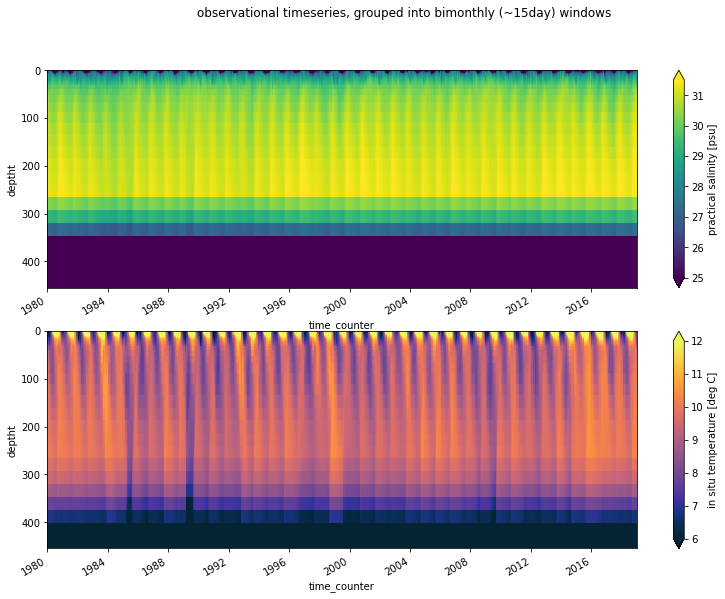

In [44]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_bm = ds2.salinity.T
xr.plot.pcolormesh(salt_bm, ax = axs[0], vmin = 25, vmax = 31.5)

temp_bm = ds2.temperature.T
xr.plot.pcolormesh(temp_bm, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

plt.suptitle('observational timeseries, grouped into bimonthly (~15day) windows')

- group by the 24 time periods and get a climatology

Text(0.5, 0.98, 'model climatology of T and S \n biweekly time-periods')

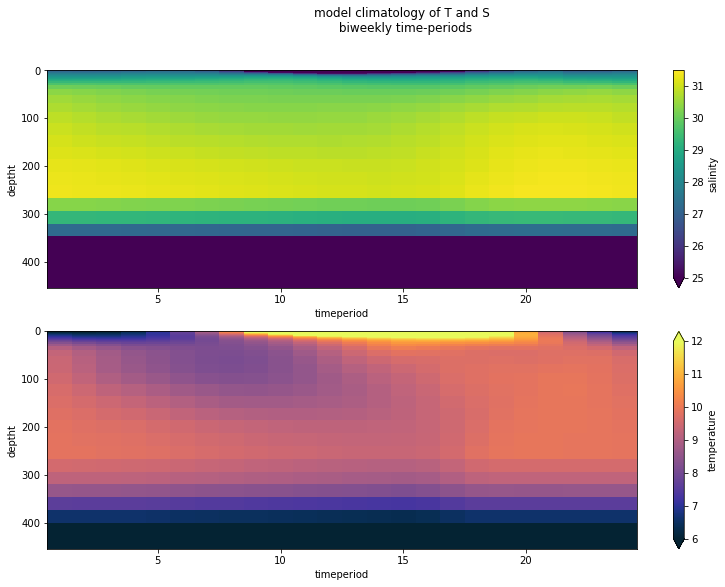

In [49]:
q = ds2.salinity.groupby(ds2.timeperiod).mean().T

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_clim = ds2.salinity.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(salt_clim, ax = axs[0], vmin = 25, vmax = 31.5)

temp_clim = ds2.temperature.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(temp_clim, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('model climatology of T and S \n biweekly time-periods')

- detrend (ie, for each time series point, subtract the climatology and visualize the departures

In [50]:
saltts_minusclim = salt_bm.groupby(ds2.timeperiod)-salt_clim
tempts_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim

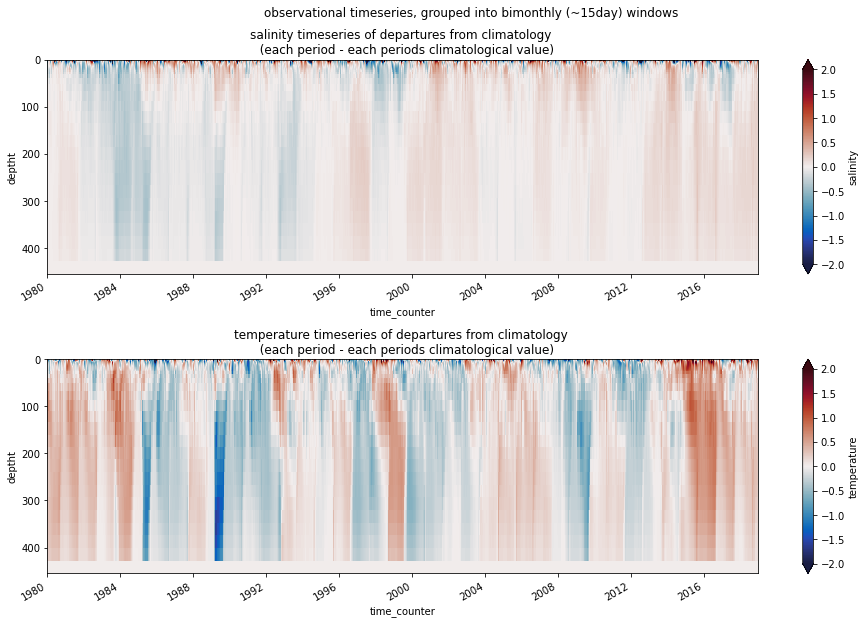

In [51]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

xr.plot.pcolormesh(saltts_minusclim, ax = axs[0], cmap = cm.cm.balance, vmin = -2, vmax = 2)

xr.plot.pcolormesh(tempts_minusclim, ax = axs[1], cmap = cm.cm.balance, vmin = -2, vmax = 2)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[0].set_title('salinity timeseries of departures from climatology \n  (each period - each periods climatological value)')
axs[1].set_title('temperature timeseries of departures from climatology \n  (each period - each periods climatological value)')

plt.suptitle('observational timeseries, grouped into bimonthly (~15day) windows')
plt.tight_layout()

- visualize the timeseries of top-10-m temperatures
- reformat into numbers (years as number) and calculate a linear trend

Text(0.5, 0.98, 'Nanoose Bay model temperatures, top 10 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

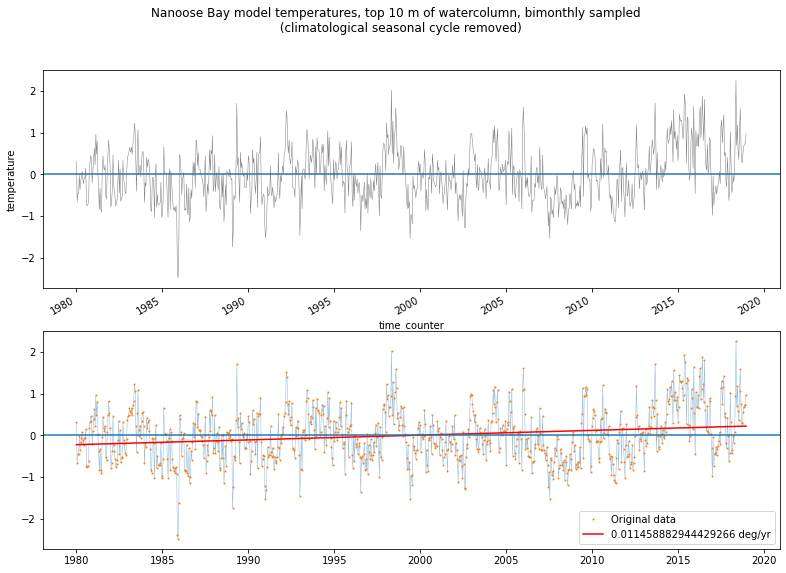

In [53]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

top10mtemp = tempts_minusclim.isel(deptht = tempts_minusclim.deptht <10.5).mean(dim = 'deptht')

top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
axs[0].axhline(y=0)


## get it from datetimes to numbers to find trend in a per/year thing
tyr = np.arange(1980,2019,(1/24))
axs[1].plot(tyr,top10mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(top10mtemp.values)]
y = top10mtemp.values[~np.isnan(top10mtemp.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Original data', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{m} deg/yr')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Nanoose Bay model temperatures, top 10 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')